# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [27]:
# Change here using YOUR first and last names
fn1 = "Rémy"
ln1 = "Soukarie"
fn2 = "Benjamin"
ln2 = "Muller"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_soukarie_rémy_and_muller_benjamin.ipynb


In [28]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
np.random.seed(42)

np.set_printoptions(precision=20)  # to have simpler print outputs with numpy

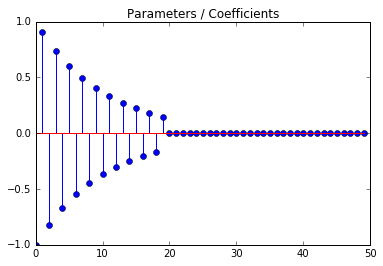

In [73]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)

coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [30]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    #print cov
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [1]:
def prox_lasso(x, s, t=1.):
    def max_vec(vec1): 
        return [max(0,i) for i in vec1]
    return np.sign(x)*max_vec((np.abs(x)-t*s))
    """Proximal operator for the Lasso at x with strength t"""  
    
def lasso(x, s):
    return s*np.linalg.norm(x,1)
    """Value of the Lasso penalization at x with strength t"""
#print lasso(coefs,0.1)



def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    return 1/(1+t*s)*x 
#print prox_lasso(coefs,0.1) 

def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return s/2*np.linalg.norm(x,2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

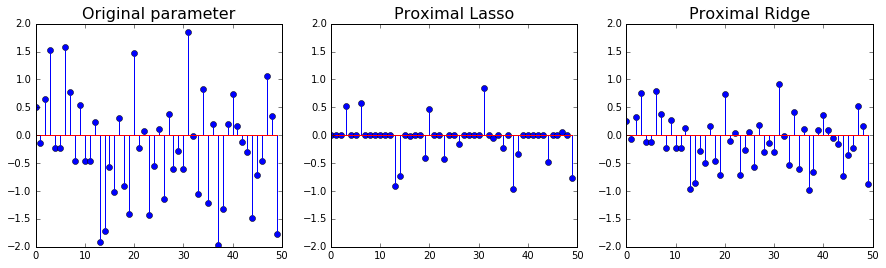

In [32]:
x = np.random.randn(50) #what is x ?array ? vector ? ....
l_l1 = 1.
l_l2 = 1.

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences):

We notice the similar rescaling behaviors fot both penalizations, on one hand we are substracting the penalization weight, on the other side we are dividing by 1+weight. The main difference relies on the threshold effect of the lasso penalization. We'll see how it impacts the convergence whitin the gradient descent algorithms



## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [72]:
y=randn(50)

def loss_linreg(x):
    A=A_lin
    b=b_lin
    n=n_lin
    return 1/(2*n)*np.square(np.linalg.norm(b-A.dot(x),ord=2))
    """Least-squares loss"""

def grad_linreg(x):
    A=A_lin
    b=b_lin
    n=n_lin
    """Leas-squares gradient"""
    return (1/n)*(np.transpose(A).dot((A.dot(x)-b))) 
    

def loss_logreg(x):
    A=A_log
    b=b_log
    n=int(n_log)
    """Logistic loss"""
    f=0
    for i in range(n):
        f=f+np.log(1.+np.exp(-b[i]*A[i].dot(x))) #replace with an array ! 
    return (1./n)*f

def grad_logreg(x):
    A=A_log
    b=b_log
    n=int(n_log)
    grad=np.zeros(50)
    for i in range(0,n):
        grad=grad-((b[i]*np.exp(-b[i]*A[i].dot(x)))/(1.+np.exp(-b[i]*A[i].dot(x))))*A[i]
    return grad/n
    """Logistic gradient"""

    
#We define A and b here for the linear case and the logistic case
A_lin,b_lin=simu_linreg(coefs)
n_lin=float(len(b_lin))

A_log,b_log=simu_logreg(coefs)
n_log=float(len(b_log))

from scipy.optimize import check_grad
print check_grad(loss_linreg,grad_linreg,y)
print check_grad(loss_logreg,grad_logreg,y)


1.97102972786e-06
1.41877055534e-06


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [34]:
def lip_linreg(A):
    n=np.shape(A)[0]
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(np.transpose(A).dot(A),2)/n 
#print lip_linreg(A_lin)


def lip_logreg(A):
    n=np.shape(A)[0]
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(np.transpose(A).dot(A),2)/(4*n) 
#print lip_linreg(A_log)

A=A_lin
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true,2) / np.linalg.norm(x_true,2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print "Lauching ISTA solver..."
        print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter + 1):
        lip=lip_linreg(A)
        #### TODO ####
        x=prox_g(x-(step)*grad_f(x),s,step)
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj-obj)
        if k % 10 == 0 and verbose:
            print ' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
    return x, objectives, errors

In [85]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print "Lauching FISTA solver..."
        print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])
    for k in range(n_iter + 1):

        x_new=prox_g(z-step*grad_f(z),s,step)
        t_new=(1+mt.sqrt(1+4*t*t))/2
        z=x_new+((t-1)/t_new)*(x_new-x)
        
        obj = f(x_new) + g(x_new, s)
        err = np.linalg.norm(x_new - x_true,2) / np.linalg.norm(x_true,2)
        errors.append(err)
        objectives.append(obj)
        
        t=t_new
        x=x_new
        
        if k % 10 == 0 and verbose:
            print ' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)])
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [74]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-5
step_lin=1/lip_linreg(A_lin)
step_log=1/lip_linreg(A_log)

#ISTA et FISTA pour le modèle linéaire avec une pénalisation ridge :

##Linear model
#ridge
x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=1000,verbose=False,s=s)
x_fista,obj_fista,err_fista = fista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=1000,verbose=False,s=s)


**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

ista minimiser
[-0.98281280781980806527  0.91387364887674948921 -0.85112944134267298768
  0.72768292822941815778 -0.6653172243788705309   0.65204528165850650367
 -0.54622037828001956949  0.52790358686895511031 -0.43077208073793782361
  0.38906451186321799884 -0.40881968756536513077  0.35626111531746867955
 -0.32161861279119929868  0.31633328772953800412 -0.25601221348774294562
  0.16337536517321366025 -0.18697499878872175794  0.20769201229987505064
 -0.14212016080746089908  0.18046144216298895535  0.06035173777158411162
 -0.07113419379536341236  0.00651287709977512678  0.03557647324041282588
 -0.05262069833571596245  0.08174464115601969005 -0.05837262795993851394
  0.0443232043454369895   0.08001332582977238594 -0.08893932666105390517
  0.05512813033248985944  0.04404402373492350559 -0.04524590268537883458
 -0.01829070619061030911  0.02215911309146513519 -0.03084747965545936443
 -0.02395688681746926951  0.03861513277076872308  0.02954016813787164325
 -0.03462053318119865525  0.05162484

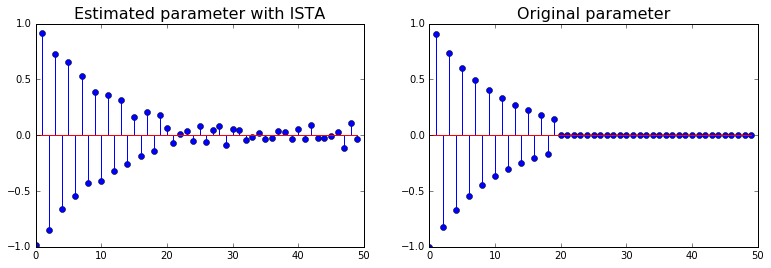

In [75]:
# Both algorithms leads to the sames x* . We output it here and we plot it next to the true original vector to have a sense of the difference.
print "ista minimiser"
print x_ista 
print "fista minimser"
print x_fista

plt.figure(figsize=(20.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x_ista)
plt.title("Estimated parameter with ISTA", fontsize=16)
plt.subplot(1, 3, 2)
plt.stem(coefs)
plt.title("Original parameter", fontsize=16)


In [37]:
#On compare désormais les convergences : 200 itérations sont suffisantes 
x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False)
x_fista,obj_fista,err_fista = fista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False)

from bokeh.palettes import RdYlGn5
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file, reset_output, gridplot, save


n_iter=len(err_fista)
reset_output()
output_notebook()
p = figure(title='Convergence Comparison ', y_axis_type="log", plot_width=450, plot_height=500)
p.xaxis.axis_label='iterations'
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label='Distance to the minimiser'
p.yaxis.axis_label_text_font_size = "12pt"
p.line(range(n_iter), err_fista, color='darkgreen', legend='FISTA')
p.line(range(n_iter), err_ista, color='darkred', legend='ISTA')
show(p)
q = figure(title='Convergence Comparison', y_axis_type="log", plot_width=450, plot_height=500)
q.xaxis.axis_label='iterations'
q.yaxis.axis_label='Distance to the minimum'
q.xaxis.axis_label_text_font_size = "12pt"
q.yaxis.axis_label_text_font_size = "12pt"
q.line(range(n_iter), obj_fista, color='darkgreen', legend='FISTA')
q.line(range(n_iter), obj_ista, color='darkred', legend='ISTA')
show(q)




Loading BokehJS ...

Comments : 

In terms of final solution ISTA and FISTA reach the same minimum after around 1000 iterations. 
We notice here, in the case of the linear model and ridge penalization that the convergence is indeed much faster with FISTA than ISTA. With around 10 iterations we reached a very small error and we are very close to the minimum, compared with around 30 iterations for ISTA.
The tradeoff as we've seen theoretically, is that the objective is not necessarily always decreasing. 


**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

In [51]:
s = 1e-5

#let's study the influence of the corelation cov on both algorithms
# we start with linear model and ridge penalization 
dic={}
reset_output()
output_notebook()
color0=['#3288bd', '#99d594', '#e6f598', '#fee08b', '#fc8d59', '#d53e4f',"green","blue","red","yellow"]
r = figure(title='Convergence Comparison : Linear model', y_axis_type="log", plot_width=450, plot_height=500)
r.xaxis.axis_label='iterations'
r.xaxis.axis_label_text_font_size = "12pt"
r.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(0,5):
    cov=idx*0.2
    A_lin,b_lin=simu_linreg(coefs,corr=cov)
    n_lin=float(len(b_lin))
    step_lin=1/lip_linreg(A_lin)
    x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False)
    n_iter=len(err_ista)
    dic[cov]=err_ista
    r.line(range(n_iter), err_ista, color=color0[i], legend='ISTA'+str(cov)+"cov")
    i=i+1
show(r)
#same for FISTA 
rf = figure(title='Convergence Comparison : Linear model', y_axis_type="log", plot_width=450, plot_height=500)
rf.xaxis.axis_label='iterations'
rf.yaxis.axis_label='Distance to the minimiser'
rf.xaxis.axis_label_text_font_size = "12pt"
rf.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(0,5):
    cov=idx*0.2
    A_lin,b_lin=simu_linreg(coefs,corr=cov)
    n_lin=float(len(b_lin))
    step_lin=1/lip_linreg(A_lin)
    x_fista,obj_fista,err_fista = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False)
    n_iter=len(err_fista)
    dic[cov]=err_fista
    rf.line(range(n_iter), err_fista, color=color0[i], legend='FISTA'+str(cov)+"cov")
    i=i+1
show(rf)
#now Logistic ISTA
rlog = figure(title='Convergence Comparison : Logistic model', y_axis_type="log", plot_width=450, plot_height=500)
rlog.xaxis.axis_label='iterations'
rlog.yaxis.axis_label='Distance to the minimiser'
rlog.xaxis.axis_label_text_font_size = "12pt"
rlog.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(0,5):
    cov=idx*0.2
    A_log,b_log=simu_logreg(coefs,corr=cov)
    n_log=float(len(b_log))
    step_log=1/lip_linreg(A_log)
    x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=ridge,prox_g=prox_ridge,step=step_log,n_iter=200,verbose=False)
    n_iter=len(err_ista)
    dic[cov]=err_ista
    rlog.line(range(n_iter), err_ista, color=color0[i], legend='ISTA'+str(cov)+"cov")
    i=i+1
show(rlog)
#logistic FISTA
rlogf = figure(title='Convergence : Logistic model', y_axis_type="log", plot_width=450, plot_height=500)
rlogf.xaxis.axis_label='iterations'
r.yaxis.axis_label='Distance to the minimiser
rlogf.xaxis.axis_label_text_font_size = "12pt"
rlogf.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(0,5):
    cov=idx*0.2
    A_log,b_log=simu_logreg(coefs,corr=cov)
    n_log=float(len(b_log))
    step_log=1/lip_linreg(A_log)
    x_fista,obj_fista,err_fista = fista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=ridge,prox_g=prox_ridge,step=step_log,n_iter=200,verbose=False)
    n_iter=len(err_fista)
    dic[cov]=err_fista
    rlogf.line(range(n_iter), err_fista, color=color0[i], legend='FISTA'+str(cov)+"cov")
    i=i+1
show(rlogf)



Loading BokehJS ...

Linear model, ridge penalisation, ISTA optimisation : 

We notice that the more correlated the inputs are the slower the convergence.
It's the same for the FISTA otpmisation. 
We observe the same dynamic for the logistic model but with a more extensive extent. 
Algorithmically, the more corelated the predictors are, the higher the norm of AtA and the smaller the Lipschitz constant. That's why it induces a slower convergence.
For the linear case, we can understand that through a theoretical reason also. Indeed, the variance of our estimator is proportional to 1/(1-R_j) (whith R_j the R-square of one regressor j to the other) which means that the more corelated the input are the higher the variance of the estimator. In practice, we visualise this here by noticing that the error is much higher when the corelation is high. 
In terms of bias-variance tradeoff, we observe a high bias when s is high, because x is very constrained. Conversely, when s is small the bias is small but the variance is bigger.


In [57]:
#2 study the level of the ridge impact on optimisation on both models : s 

#Now our data are not changing anymore, we observe the effect of the ridge pernalization 
A_lin,b_lin=simu_linreg(coefs)
n_lin=float(len(b_lin))
step_lin=1/lip_linreg(A_lin)
#
A_log,b_log=simu_logreg(coefs,corr=s)
n_log=float(len(b_log))
step_log=1/lip_linreg(A_log)
   
dic={}
reset_output()
output_notebook()
color0=['#3288bd', '#99d594', '#e6f598', '#fee08b', '#fc8d59', '#d53e4f',"green","blue","red","yellow"]
r = figure(title='Convergence Comparison : Linear model', y_axis_type="log", plot_width=450, plot_height=500)
r.xaxis.axis_label='iterations'
r.yaxis.axis_label='Distance to the minimiser'
r.xaxis.axis_label_text_font_size = "12pt"
r.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(1,6):
    s=10**-idx
    x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False,s=s)
    n_iter=len(err_ista)
    dic[s]=err_ista
    r.line(range(n_iter), err_ista, color=color0[i], legend='ISTA'+str(s)+"pen")
    i=i+1
show(r)
#now Logistic ISTA
rlog = figure(title='Convergence Comparison : Logistic model', y_axis_type="log", plot_width=450, plot_height=500)
rlog.xaxis.axis_label='iterations'
r.yaxis.axis_label='Distance to the minimiser'
rlog.xaxis.axis_label_text_font_size = "12pt"
rlog.yaxis.axis_label_text_font_size = "12pt"
i=0
for idx in range(1,6):
    s=10**-idx
    x_ista,obj_ista,err_ista = ista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=ridge,s=s,prox_g=prox_ridge,step=step_log,n_iter=200,verbose=False)
    n_iter=len(err_ista)
    dic[s]=err_ista
    rlog.line(range(n_iter), err_ista, color=color0[i], legend='ISTA'+str(s)+"pen")
    i=i+1
show(rlog)



Loading BokehJS ...

In the case of the ridge, the bigger the penalisation the worse the convergence in the sense that we are much closer to the true parameter when the penalisation is very small. 
We can interpret that in terms of over/underfitting. Indeed, by taking a high penalization, we assume a very law complexity of the true model. By doing that too much, we underfit the data and we're not able to reach the true parameter. 

In [95]:
#Let's compare the impact of the regularization function among Lasso and Ridge on the performance
s=10**-2
#For the linear model
#ridge
x_ista_r,obj_ista_r,err_ista_r = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False,s=s)
x_fista_r,obj_fista_r,err_fista_r = fista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=ridge,prox_g=prox_ridge,step=step_lin,n_iter=200,verbose=False,s=s)
#lasso
x_ista_l,obj_ista_l,err_ista_l = ista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=lasso,prox_g=prox_lasso,step=step_lin,n_iter=200,s=s,verbose=False)
x_fista_l,obj_fista_l,err_fista_l = fista(x0=x0,f=loss_linreg,grad_f=grad_linreg,g=lasso,prox_g=prox_lasso,step=step_lin,n_iter=200,s=s,verbose=False)
n_iter=len(err_ista)
reset_output()
output_notebook()
p = figure(title='Convergence Comparison Linear - ISTA/FISTA', y_axis_type="log", plot_width=450, plot_height=500)
p.xaxis.axis_label='iterations'
p.yaxis.axis_label='Distance to the minimiser'
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.line(range(n_iter), err_ista_r, color='darkgreen', legend='ridge ISTA')
p.line(range(n_iter), err_ista_l, color='darkred', legend='lasso ISTA')
p.line(range(n_iter), err_fista_r, color='blue', legend='ridge FISTA')
p.line(range(n_iter), err_fista_l, color='orange', legend='lasso FISTA')
show(p)


#Logistic model with ISTA and FISTA
#ridge
x_ista_r,obj_ista_r,err_ista_r = ista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=ridge,prox_g=prox_ridge,step=step_log,n_iter=400,s=s,verbose=False)
x_fista_r,obj_fista_r,err_fista_r = fista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=ridge,prox_g=prox_ridge,step=step_log,n_iter=400,s=s,verbose=False)
#lasso
x_ista_l,obj_ista_l,err_ista_l = ista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=lasso,prox_g=prox_lasso,step=step_log,n_iter=400,s=s,verbose=False)
x_fista_l,obj_fista_l,err_fista_l = fista(x0=x0,f=loss_logreg,grad_f=grad_logreg,g=lasso,prox_g=prox_lasso,step=step_log,n_iter=400,s=s,verbose=False)
output_notebook()
pr = figure(title='Convergence Comparison Logistic - ISTA/FISTA', y_axis_type="log", plot_width=450, plot_height=500)
pr.xaxis.axis_label='iterations'
pr.yaxis.axis_label='Distance to the minimiser'
pr.xaxis.axis_label_text_font_size = "12pt"
pr.yaxis.axis_label_text_font_size = "12pt"
pr.line(range(n_iter), err_ista_r, color='darkgreen', legend='ridge ISTA')
pr.line(range(n_iter), err_ista_l, color='darkred', legend='lasso ISTA')
pr.line(range(n_iter), err_fista_r, color='blue', legend='ridge FISTA')
pr.line(range(n_iter), err_fista_l, color='orange', legend='lasso FISTA')
show(pr)


Loading BokehJS ...

Loading BokehJS ...

We notice a different behavior for the Linear model and the Logistic model. 
If s is very small, the penalization has a non-significant impact on the convergence.
An order of magnitude higher (10-3) the Lasso is better for both models
Another order higher (10-2) and the Lasso becomes better for the Linear but not for the Logistic model. 
Another order higher (10-1) and the Ridge is the best for both models. This last part is easily understandable, because if s is thoo high, the lasso set to 0 most of the coordinates which makes the convergence impossible.  
This shows the need to test in practice different kind of penalization function in order to reach the best solution because this choice is clearly model-dependant.
To find some theoretical foundation for a such decision, a solution would be to look at the bayesian interpretation of the regularization function. 
